In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import anndata
import networkx as nx
import scvelo as scv

from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from RnaVeloDataset import RnaVeloDataset

import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from torch_geometric.data import DataLoader
from RnaVeloDataset import RnaVeloDataset
from model.BaseModel import BaseModel
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
root = "data/"
bif_batch1 = [("bifur1", tr, 1, 1, nc) for tr in [3, 5] for nc in [100, 150, 200, 250, 300]]
linear_simple_10 = [("linear_simple", 2, 5, sr, nc) for sr in [1, 5] for nc in [220, 240, 260, 280, 300]]

combined = bif_batch1 + linear_simple_10
adata_list = []

for item in combined:

    if item[0] == "linear_simple":
        bb, sd, tr, sr, nc = item
        path = root + bb + "_" + str(sd) + "_" + str(tr) + "_" + str(sr) + "_" + str(nc)
    if item[0] == "bifur1":
                bb, tr, sr, dg, nc = item
                path = root + "bif_batch1/bifurcating_" + str(tr) + "_1_1_" + str(nc)
    print(path)

    df = pd.read_csv(path + "_unspliced.csv")
    df = df.drop(df.columns[[0]], axis=1)
    X_unspliced = df.to_numpy()

    df = pd.read_csv(path + "_spliced.csv")
    df = df.drop(df.columns[[0]], axis=1)
    X_spliced = df.to_numpy()

    df = pd.read_csv(path + "_cell_info.csv")
    df = df.drop(df.columns[[0]], axis=1)
    X_obs = df

    adata = anndata.AnnData(X = csr_matrix(X_spliced),
                    obs = X_obs,
                    layers = dict(
                        unspliced = csr_matrix(X_unspliced),
                        spliced = csr_matrix(X_spliced)
                    ))
    adata_list.append(adata)

len(adata_list)

data/bif_batch1/bifurcating_3_1_1_100
Transforming to str index.
data/bif_batch1/bifurcating_3_1_1_150
Transforming to str index.
data/bif_batch1/bifurcating_3_1_1_200
Transforming to str index.
data/bif_batch1/bifurcating_3_1_1_250
Transforming to str index.
data/bif_batch1/bifurcating_3_1_1_300
Transforming to str index.
data/bif_batch1/bifurcating_5_1_1_100
Transforming to str index.
data/bif_batch1/bifurcating_5_1_1_150
Transforming to str index.
data/bif_batch1/bifurcating_5_1_1_200
Transforming to str index.
data/bif_batch1/bifurcating_5_1_1_250
Transforming to str index.
data/bif_batch1/bifurcating_5_1_1_300
Transforming to str index.
data/linear_simple_2_5_1_220
Transforming to str index.
data/linear_simple_2_5_1_240
Transforming to str index.
data/linear_simple_2_5_1_260
Transforming to str index.
data/linear_simple_2_5_1_280
Transforming to str index.
data/linear_simple_2_5_1_300
Transforming to str index.
data/linear_simple_2_5_5_220
Transforming to str index.
data/linear_si

20

In [4]:
dataset = RnaVeloDataset(root='data/')
len(dataset)

shed(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
Data(adata=AnnData object with n_obs × n_vars = 250 × 192 
    obs: 'cell_id', 'step_ix', 'simulation_i', 'sim_time', 'num_molecules', 'mult', 'lib_size', 'n_counts', 'velocity_self_transition'
    var: 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_settings', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'unspliced', 'spliced'

20

In [21]:
train_mask = list(range(8)) + list(range(10, 18))
val_mask = [8, 9, 18, 19]

In [22]:
def train():
    model.train()

    total_loss = 0
    mse = nn.MSELoss()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y.to(device)
        loss = torch.sqrt(mse(output, label))
        loss.backward()
        total_loss += data.num_graphs * loss.item()
        optimizer.step()

    return float(total_loss / len(train_loader.dataset))

def test(loader):
    model.eval()
    
    correct = []
    predict = []
    for data in loader:
        data = data.to(device)
        label = data.y.detach().cpu().numpy().reshape(-1)
        pred = model(data).detach().cpu().numpy().reshape(-1)
        # print(pred.shape)
        correct.extend(label)
        predict.extend(pred)
    correct = np.array(correct)
    predict = np.array(predict)
    return sqrt(mean_squared_error(correct, predict))


In [23]:
dataset = RnaVeloDataset(root='data/')
batch_size = 2
train_loader = DataLoader(dataset[train_mask], batch_size=batch_size)
val_loader = DataLoader(dataset[val_mask], batch_size=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model = BaseModel(dataset.num_features).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4, weight_decay=0.01)

best_val_perf = test_perf = 0

train_list = []
val_list = []
for epoch in range(251):
    train_loss = train()
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    log = 'Epoch: {:03d}, Loss: {:.4f}, Train: {:.4f}, Val: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, train_acc, val_acc))
    
    train_list.append(train_acc)
    val_list.append(val_acc)

Epoch: 000, Loss: 0.5728, Train: 0.5732, Val: 0.5174
Epoch: 010, Loss: 0.5326, Train: 0.5331, Val: 0.4785
Epoch: 020, Loss: 0.4891, Train: 0.4887, Val: 0.4363
Epoch: 030, Loss: 0.4273, Train: 0.4262, Val: 0.3791
Epoch: 040, Loss: 0.3534, Train: 0.3523, Val: 0.3180
Epoch: 050, Loss: 0.2765, Train: 0.2788, Val: 0.2778
Epoch: 060, Loss: 0.2285, Train: 0.2430, Val: 0.2893
Epoch: 070, Loss: 0.2106, Train: 0.2381, Val: 0.3138
Epoch: 080, Loss: 0.2006, Train: 0.2389, Val: 0.3308
Epoch: 090, Loss: 0.1938, Train: 0.2412, Val: 0.3440
Epoch: 100, Loss: 0.1894, Train: 0.2439, Val: 0.3542
Epoch: 110, Loss: 0.1865, Train: 0.2464, Val: 0.3618
Epoch: 120, Loss: 0.1847, Train: 0.2483, Val: 0.3672
Epoch: 130, Loss: 0.1836, Train: 0.2497, Val: 0.3709
Epoch: 140, Loss: 0.1827, Train: 0.2507, Val: 0.3736
Epoch: 150, Loss: 0.1821, Train: 0.2514, Val: 0.3755
Epoch: 160, Loss: 0.1816, Train: 0.2519, Val: 0.3770
Epoch: 170, Loss: 0.1812, Train: 0.2523, Val: 0.3781
Epoch: 180, Loss: 0.1809, Train: 0.2526, Val: 

computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


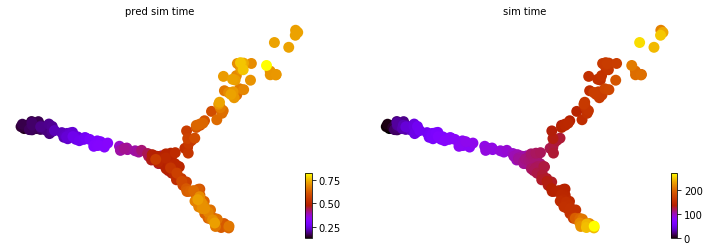

computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


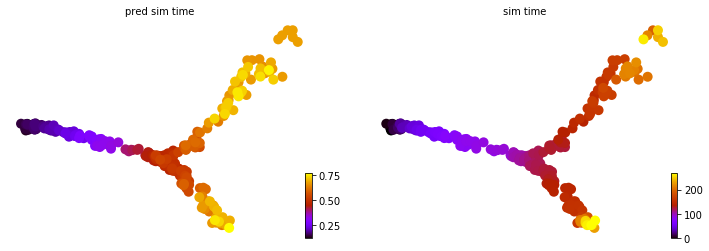

computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


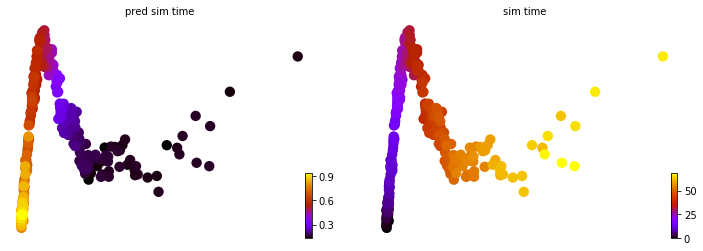

computing neighbors
    finished(0:00:00)-->added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Normalized count data:X, spliced, unspliced.
computing moments based on connectivities
    finished(0:00:00)-->added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished(0:00:00)-->added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished(0:00:00)-->added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


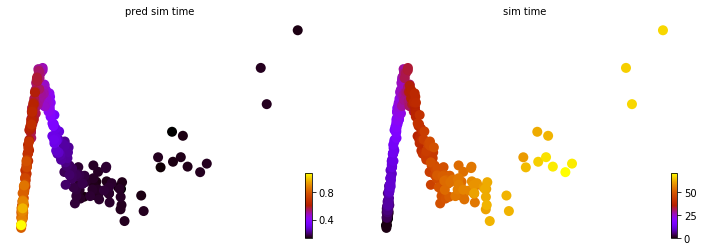

In [24]:
model.eval()
for i, data in enumerate(val_loader):
    adata = adata_list[val_mask[i]]
    scv.tl.velocity_graph(adata)
    adata.obs['pred_sim_time'] = model(data.to(device)).detach().cpu().numpy().reshape(-1)
    i += 1
    scv.pl.scatter(adata, color=['pred_sim_time','sim_time'], color_map='gnuplot', legend_loc='on data')